# Modulation Classification

We are working with the DeepSig RadioML 2016.04C. 

It's a synthetic dataset, generated with GNU Radio, consisting of 11 modulations.
This is a variable-SNR dataset with moderate LO drift, light fading, and numerous different labeled SNR increments for use in measuring performance across different signal and noise power scenarios.

## 1. Importing Dataset and Libraries


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting dataset tar file

In [4]:
# !tar -xf "/content/drive/MyDrive/Pattern/modulation-classification/RML2016.10b.tar.bz2" -C "/content/drive/MyDrive/Pattern/modulation-classification/"

In [5]:
# !ls /content/drive/MyDrive/Pattern/modulation-classification/

In [ ]:
!pip install pytorch_lightning

In [7]:
!pip install comet-ml

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
#from torchinfo import summary
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from math import isnan
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pytorch_lightning as pl
import torchmetrics
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [9]:
base = "/content/drive/MyDrive/Pattern/modulation-classification/"

# base = "./dataset/"

In [10]:
with open(base+'RML2016.10b.dat', 'rb')as f:
    data = pickle.load(f, encoding='bytes')

In [11]:
print(len(data.keys())) # 200 combinations

200


# 2. Creating Feature Space and Dataset



1. We have a total of 10 unique modulation types, and 20 unique values
1. In total we have 200 combinations
1. Where each combination of a modulation type and an SNR there exists 6000 samples
1. And for each combination there is a vector of (6000, 2, 128)
1. So for each combination we have 6000 sample-of-samples

In [12]:
#@title Our Modulation Domain

keys = np.array(list(data.keys()))

modulations= keys[:,0]

modulations = np.unique(modulations)

modulations = [ i.decode('utf-8') for i in modulations]


print(modulations)
print(len(modulations))

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
10


In [13]:
#@title SNR Domain
keys = np.array(list(data.keys()))

snrs= keys[:,1]

snrs = np.unique(snrs)

snrs = [ i.decode('utf-8') for i in snrs]

print(snrs)
print(len(snrs))

['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8', '0', '10', '12', '14', '16', '18', '2', '4', '6', '8']
20


In [14]:
#@title Reorganization of Data
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])
x = []  
y = []
for mod in mods:
    for snr in snrs:
        x.append(data[(mod, snr)])
        for i in range(data[(mod,snr)].shape[0]):  y.append((mod,snr))
x = np.vstack(x)
print(f"We have {x.shape} ")


We have (1200000, 2, 128) 


In [15]:
#@title Changing first value of tuple from byte str to str

labels = []

# for i,j in y:
#     new_y.append((i.decode(),j))

# y = new_y

# len(y)
# del(new_y)

labels = [(i.decode(),j) for i,j in y]


print(labels[:5])

print(len(labels))

[('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20)]
1200000


In [16]:
label_map = {item:i for i,item in enumerate(modulations)}

label_map

{'8PSK': 0,
 'AM-DSB': 1,
 'BPSK': 2,
 'CPFSK': 3,
 'GFSK': 4,
 'PAM4': 5,
 'QAM16': 6,
 'QAM64': 7,
 'QPSK': 8,
 'WBFM': 9}

In [17]:
class ModulationDatasetClass(Dataset):
    def __init__(self, data, labels, feature_space='raw', snr_allowed = []):
        self.raw_samples = data
        self.samples = []
        self.labels = labels
        self.feature_space= feature_space
        self.snr_allowed = snr_allowed
        self.setup_feature_space()
        self.setup_final_samples()

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)

    def setup_feature_space(self):
        if self.feature_space == 'raw':
            #print('raw')
            pass

        elif self.feature_space == 'dt':
            #print('dt')
            for idx in range(self.raw_samples.shape[0]):
                for channel in range(self.raw_samples.shape[1]):
                    self.raw_samples[idx][channel] =  np.gradient(self.raw_samples[idx][channel])

        elif self.feature_space == 'integral':
            print('integral')
            for idx in range(self.raw_samples.shape[0]):
                for channel in range(self.raw_samples.shape[1]):
                    self.raw_samples[idx][channel] =  np.cumsum(self.raw_samples[idx][channel])
                     
        elif self.feature_space == 'mix':
            print("mix")
            raw_samples = np.zeros((self.raw_samples.shape[0],4,self.raw_samples.shape[2]))
            # samples['all'] = np.hstack([samples['time'],samples['integral'],samples['dt']]).shape
            for idx in range(raw_samples.shape[0]):
                for channel in range(2): # dt + integral # hmm?
                    raw_samples[idx][channel] =  np.gradient(self.raw_samples[idx][channel])
                    raw_samples[idx][channel+1] =  np.cumsum(self.raw_samples[idx][channel])

            self.raw_samples = raw_samples
        

    def setup_final_samples(self):
        for idx in range(len(self.raw_samples)):
            sample = {'data':self.raw_samples[idx], 
                      'real_label': self.labels[idx],
                      'label': label_map[self.labels[idx][0]]}
            if not self.snr_allowed or self.labels[idx][1] in self.snr_allowed or len(self.snr_allowed) == 0:
                self.samples.append(sample)
        del(self.raw_samples)




## DataLoader Creation

In [18]:
class ModulationDataloaders(DataLoader):
    def __init__(self, train_set = None, val_set=None, test_set=None, batch_size=4):
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.define_loaders()

    def define_loaders(self):
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, \
                                       shuffle=True, num_workers=1)
        self.val_loader = DataLoader(self.val_set, batch_size=self.batch_size, \
                                     shuffle=False, num_workers=1)
        if self.test_set is not None:
            self.test_loader = DataLoader(self.test_set, batch_size=self.batch_size, \
                                         shuffle=False, num_workers=1)
    def get_train_loader(self):
        return self.train_loader

    def get_val_loader(self):
        return self.val_loader

    def get_test_loader(self):
        return self.test_loader

# 3. Supervised Learning Step

## Splitting samples into train, test, validation sets

In [19]:
#@title Splitting the data
x_total = x
y_total = labels

# a. Split the data into 70% for training/validation and 30% for testing.
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total , train_size = 0.7, test_size = 0.3, shuffle= True, stratify = y_total)

# b. Use 5% of the training and validation dataset for validation.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.95, test_size = 0.05, shuffle= True, stratify = y_train)


print(x_train.shape,x_test.shape,x_val.shape)
print(len(y_train),len(y_test),len(y_val))

# TODO GRAPH OF SPLITS

(798000, 2, 128) (360000, 2, 128) (42000, 2, 128)
798000 360000 42000


In [20]:
# Raw set
train_set_raw = ModulationDatasetClass(x_train, y_train, feature_space='raw', snr_allowed = [])
val_set_raw = ModulationDatasetClass(x_val, y_val, feature_space='raw', snr_allowed = [])

In [19]:
# Derivative set
train_set_dt = ModulationDatasetClass(x_train, y_train, feature_space='dt', snr_allowed = [])
val_set_dt = ModulationDatasetClass(x_val, y_val, feature_space='dt', snr_allowed = [])
# train_set_dt = None
# val_set_dt = None
# Integral set
train_set_integral = None
val_set_integral = None
# Combinations set
train_set_mix = None
val_set_mix = None
# # Integral set
# train_set_integral = ModulationDatasetClass(x_train, y_train, feature_space='integral', snr_allowed = [])
# val_set_integral = ModulationDatasetClass(x_val, y_val, feature_space='integral', snr_allowed = [])
# # Combinations set
# train_set_mix = ModulationDatasetClass(x_train, y_train, feature_space='mix', snr_allowed = [])
# val_set_mix = ModulationDatasetClass(x_val, y_val, feature_space='mix', snr_allowed = [])
# test_set_raw = ModulationDatasetClass(data, labels, feature_space='raw', snr_allowed = [])


dt
dt


## CNN Model

In [21]:
import torch.nn.functional as F
from torch.autograd import Variable

class OurCNN(nn.Module):
    def __init__(self, num_classes, input_shape=(2, 128)):
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.batchnorm = nn.BatchNorm2d(2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(1, 3),
                stride=1,
                padding='same'
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=16,
                kernel_size=(2, 3),
                stride=1,
                padding='same'
            ),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        n_size = self._get_conv_output(self.input_shape)
        self.linear_1 = nn.Linear(n_size, 128)
        self.linear_2 = nn.Linear(128, 10)

    def forward(self, input):
        x = torch.unsqueeze(input, dim=1)
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        #x = self.softmax(x)
        return x

    def _get_conv_output(self, shape):
        bs = 1
        input_data = Variable(torch.rand(bs, *shape))
        input_data = torch.unsqueeze(input_data, dim=1)
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.flatten(x)
        n_size = x.data.view(bs, -1).size(1)
        return n_size

## OurRNN

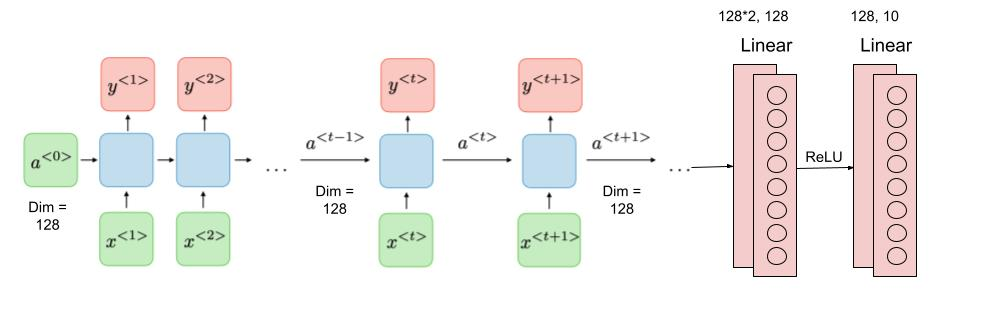

In [28]:
import torch.nn.functional as F
from torch.autograd import Variable

class OurRNN(nn.Module):

    def __init__(self, num_classes, input_dim, hidden_dim):
        super().__init__()
        #self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.device = "cpu"
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batchnorm = nn.BatchNorm1d(2)
        self.rnn = nn.RNN(
            input_size=input_dim, 
            hidden_size=hidden_dim,
            num_layers = 1, 
            batch_first=True,
            nonlinearity='tanh')
        self.fc1 = nn.Linear(hidden_dim*2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.batchnorm(x)
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(self.device)
        out, hn = self.rnn(x, h0)
        out = out.contiguous().view(x.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## OurLSTM

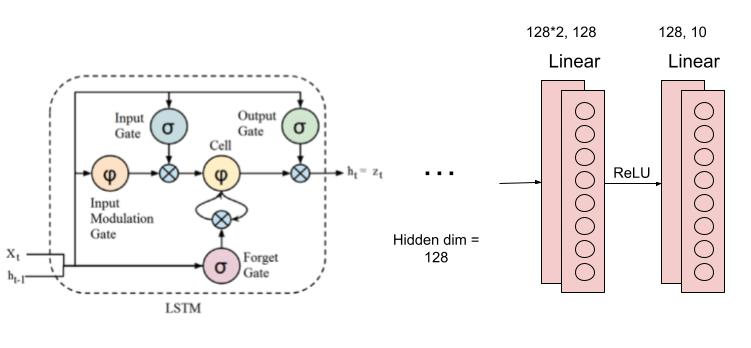

In [27]:
class OurLSTM(nn.Module):

    def __init__(self, num_classes, input_dim, hidden_dim):
        super().__init__()
        #self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.device = "cpu"
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batchnorm = nn.BatchNorm1d(2)
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim,
            num_layers = 1, 
            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim*2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.batchnorm(x)
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(self.device)
        c0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(self.device)
        out, (hn, cn) = self.lstm(x, (h0,c0))
        out = out.contiguous().view(x.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Conv-LSTM


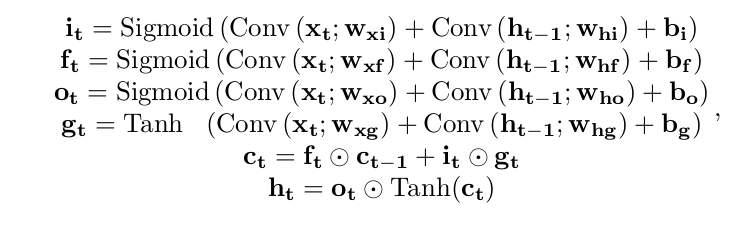

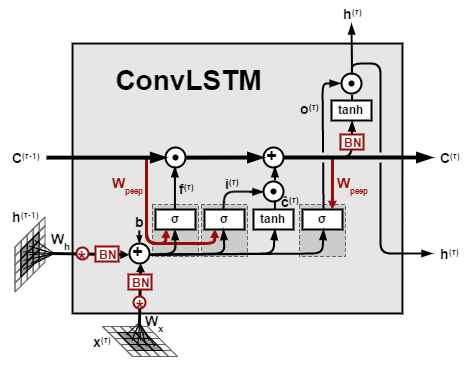

In [ ]:
# TODO

## Training

In [22]:
class ClassificationModel(pl.LightningModule):
    
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, model=None, lr=0.001, average='micro'):
        super().__init__()
        self.model = model
        self.lr = lr
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.loss_fn = nn.CrossEntropyLoss()
        self.average = average
        self.train_accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10, average=self.average)
        self.val_accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10, average=self.average)
        self.train_f1_fn = torchmetrics.F1Score(task="multiclass", num_classes=10, average=self.average)
        self.val_f1_fn = torchmetrics.F1Score(task="multiclass", num_classes=10, average=self.average)

    def forward(self, data):
        outputs = self.model(data)
        return outputs
        

    def training_step(self, batch, batch_idx):
        labels = batch["label"]
        data = batch["data"]
        outputs = self(data)
        # print("labels", labels, labels.shape)
        # print("outputs", outputs, outputs.shape)
        loss = self.loss_fn(outputs, labels)
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = torch.squeeze(preds, dim=1)
        self.train_accuracy_fn.update(preds, labels)
        self.train_f1_fn.update(preds, labels)

        sklearn_acc = accuracy_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy())
        sklearn_prec = precision_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_recall = recall_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_f1 = f1_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average)
        metrics = {'loss': loss, 'train_sklearn_acc': sklearn_acc, 'train_sklearn_prec': sklearn_prec, \
                   'train_sklearn_recall': sklearn_recall, 'train_sklearn_f1': sklearn_f1}   

        for k,v in metrics.items():
            self.log(k,v, on_step=True, on_epoch=True)       
        return(metrics)
    
    def training_epoch_end(self, outputs):
        self.log('train_acc_epoch', self.train_accuracy_fn.compute())
        self.log('train_f1_epoch', self.train_f1_fn.compute())
        self.train_accuracy_fn.reset()
    
    def validation_step(self, batch, batch_idx):
        labels = batch["label"]
        # labels = torch.squeeze(labels, dim=1)
        data = batch["data"]
        outputs = self(data)
        #print("OUTPUTS: ", outputs)
        loss = self.loss_fn(outputs, labels)
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = torch.squeeze(preds, dim=1)
        self.val_accuracy_fn.update(preds, labels)
        self.val_f1_fn.update(preds, labels)


        sklearn_acc = accuracy_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy())
        sklearn_prec = precision_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_recall = recall_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average, zero_division=1)
        sklearn_f1 = f1_score(preds.detach().cpu().numpy(), labels.detach().cpu().numpy(), average=self.average)
        metrics = {'val_loss': loss, 'val_sklearn_acc': sklearn_acc, 'val_sklearn_prec': sklearn_prec, \
                   'val_sklearn_recall': sklearn_recall, 'val_sklearn_f1': sklearn_f1}   
                     
        for k,v in metrics.items():
            self.log(k,v, on_step=True, on_epoch=True)       
        return(metrics)
    
    def validation_epoch_end(self, outputs):
        self.log('val_acc_epoch', self.val_accuracy_fn.compute())
        self.log('val_f1_epoch', self.val_f1_fn.compute())
        self.val_accuracy_fn.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    # def test_dataloader(self):
    #     return self.test_dl


In [ ]:
import os
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger
from comet_ml import Experiment


def main(hyperparams, model_name='OurCNN', feature='raw'):

    if feature == 'raw':
        train_set = train_set_raw
        val_set = val_set_raw
    elif feature == 'dt':
        train_set = train_set_dt
        val_set = val_set_dt
    elif feature == 'integral':
        train_set = train_set_dt
        val_set = val_set_integral
    elif feature == 'mix':
        train_set = train_set_mix
        val_set = val_set_mix

    # DataLoader
    loader = ModulationDataloaders(train_set, val_set, batch_size = hyperparams["batch_size"])
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()

    input_shape = next(iter(val_loader))['data'][1].shape

    n_epochs = hyperparams["n_epochs"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    average = hyperparams["average"]
    hidden_dim = hyperparams["hidden_dim"]
    input_dim = hyperparams["input_dim"]


    os.makedirs(base + "checkpoints", exist_ok=True)

    exp_name = f"{model_name}_{feature}_colab_{n_epochs}epochs_b{batch_size}_lr{lr}_{average}"
    
    checkpoint_accuracy = ModelCheckpoint(dirpath=base + f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_acc_epoch:.5f}', \
                                          save_top_k=5, monitor="val_acc_epoch", mode="max")

    checkpoint_f1 = ModelCheckpoint(dirpath=base+ f"checkpoints/{exp_name}", filename='{epoch}_{step}_{val_f1_epoch:.5f}', \
                                          save_top_k=5, monitor="val_f1_epoch", mode="max")
    comet_logger = CometLogger(
        api_key="aeMY8tfwoN3PJFejHzxLryDa3",
        project_name="modulation",
        workspace="nour-hesham",
        experiment_name=exp_name 
    )
    
    trainer = pl.Trainer(logger=comet_logger,
                         gpus=1,
                         #accelerator="cpu", 
                         devices=1, 
                         callbacks=[checkpoint_accuracy, checkpoint_f1], 
                         max_epochs=hyperparams["n_epochs"],
                         log_every_n_steps=4
                         )

    comet_logger.log_hyperparams(hyperparams)


    if model_name == 'OurCNN': 
        initial_model = OurCNN(num_classes=10, input_shape=input_shape)
    elif model_name == 'OurRNN':
        initial_model = OurRNN(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    elif model_name == 'OurLSTM':
        initial_model = OurLSTM(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    else:
        initial_model = None
        exit(1)

    model = ClassificationModel(train_loader, val_loader, model=initial_model, lr=lr, average=hyperparams['average'])
    
    trainer.fit(model)

In [ ]:
hyperparams = {"lr": 0.001, "n_epochs": 10, "batch_size": 256, "optim": "Adam", "average":'weighted', "hidden_dim": 128, "input_dim": 128}

In [ ]:
import gc

gc.collect()

2334

In [ ]:
main(hyperparams, 'OurLSTM', 'dt')

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:487: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: Comet has disabled auto-logging functionality as it has

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/6f1f79556a0a4aea9021337c0806d359
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.4497098922729492, 1.8823349475860596)
COMET INFO:     loss_step [7795]                 : (1.287624478340149, 2.3109192848205566)
COMET INFO:     train_acc_epoch [10]             : (0.24631327390670776, 0.37055012583732605)
COMET INFO:     train_f1_epoch [10]              : (0.2320438027381897, 0.3275472819805145)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.24631328320802004, 0.3705501253132832)
COMET INFO:     train_sklearn_acc_step [7795]    : (0.07421875, 0.50390625)
COMET INFO:     train_sklearn

In [ ]:
main(hyperparams, 'OurCNN', 'dt')

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:487: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: Comet has disabled auto-logging functionality as it has

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/9998bc2dab5c47e9b5919402931aab87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.596387505531311, 1.786604642868042)
COMET INFO:     loss_step [7795]                 : (1.4180247783660889, 2.3385283946990967)
COMET INFO:     train_acc_epoch [10]             : (0.26993608474731445, 0.31773561239242554)
COMET INFO:     train_f1_epoch [10]              : (0.26561853289604187, 0.2988400161266327)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.2699360902255639, 0.3177355889724311)
COMET INFO:     train_sklearn_acc_step [7795]    : (0.07421875, 0.4140625)
COMET INFO:     train_sklearn_f

In [ ]:
main(hyperparams, 'OurRNN', 'dt')

INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:487: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: Comet has disabled auto-logging functionality as it has

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/d72f3d7f9e5b45049923605b340e54b0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.571265697479248, 1.9943344593048096)
COMET INFO:     loss_step [7795]                 : (1.3376134634017944, 2.3154616355895996)
COMET INFO:     train_acc_epoch [10]             : (0.22155889868736267, 0.3347155451774597)
COMET INFO:     train_f1_epoch [10]              : (0.2068636417388916, 0.28588390350341797)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.22155889724310776, 0.3347155388471178)
COMET INFO:     train_sklearn_acc_step [77

## Hyperparameter tuning

In [ ]:
lrs = [1e-04, 5e-04, 5e-03]


for lr in lrs:
    hyperparams = {"lr": lr, "n_epochs": 10, "batch_size": 256, "optim": "Adam", "average":'weighted', "hidden_dim": 128, "input_dim": 128}
    main(hyperparams, "OurCNN", 'raw')
    main(hyperparams, "OurRNN", 'raw')
    main(hyperparams, "OurLSTM", 'raw')


INFO:pytorch_lightning.loggers.comet:CometLogger will be initialized in online mode
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:487: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: Comet has disabled auto-logging functionality as it has

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 48. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/8b9b8ffd89fe4b57ad7819c597e4758c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.1671382188796997, 1.6489129066467285)
COMET INFO:     loss_step [7795]                 : (0.9687379002571106, 2.3116188049316406)
COMET INFO:     train_acc_epoch [10]             : (0.35236966609954834, 0.5101641416549683)
COMET INFO:     train_f1_epoch [10]              : (0.3491755425930023, 0.4738723635673523)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.35236967418546367, 0.5101641604010025)
COMET INFO:     train_sklearn_acc_step [7795]    : (0.09375, 0.6171875)
COMET INFO:     train_sklearn_f1_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/76b0882141fd489684f5341b53165ce8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.6032754182815552, 1.950398325920105)
COMET INFO:     loss_step [7795]                 : (1.44510018825531, 2.3035190105438232)
COMET INFO:     train_acc_epoch [10]             : (0.24596741795539856, 0.37188974022865295)
COMET INFO:     train_f1_epoch [10]              : (0.233094722032547, 0.3132460117340088)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.24596741854636592, 0.37188972431077694)
COMET INFO:     train_sklearn_acc_step [7795]    : (0.09765625, 0.4609375)
COMET INFO:     train_sklearn_f1

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/1929b526d496443a821b39a48ee8814d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.4059581756591797, 1.8416677713394165)
COMET INFO:     loss_step [7795]                 : (1.244495153427124, 2.3058784008026123)
COMET INFO:     train_acc_epoch [10]             : (0.27954888343811035, 0.4151152968406677)
COMET INFO:     train_f1_epoch [10]              : (0.25048133730888367, 0.3490249514579773)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.2795488721804511, 0.4151152882205514)
COMET INFO:     train_sklearn_acc_step [7795]    : (0.078125, 0.5833333333333334)
COMET INFO:     train_sk

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/e906a985251749519b5e2dcc94fb4cc5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.1489207744598389, 1.436318039894104)
COMET INFO:     loss_step [7795]                 : (0.9371691942214966, 2.309093952178955)
COMET INFO:     train_acc_epoch [10]             : (0.4122142791748047, 0.5149473547935486)
COMET INFO:     train_f1_epoch [10]              : (0.40810924768447876, 0.49071913957595825)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.4122142857142857, 0.5149473684210526)
COMET INFO:     train_sklearn_acc_step [7795

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/1c71952a796b46efba3a07e3a5a495b3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.4832839965820312, 1.8035537004470825)
COMET INFO:     loss_step [7795]                 : (1.307754397392273, 2.294564962387085)
COMET INFO:     train_acc_epoch [10]             : (0.29671555757522583, 0.39593231678009033)
COMET INFO:     train_f1_epoch [10]              : (0.27973610162734985, 0.3506239056587219)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.2967155388471178, 0.3959323308270677)
COMET INFO:     train_sklearn_acc_step [779

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/d8d13d886f9b4312ad7a826742722b52
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.2166881561279297, 1.6348679065704346)
COMET INFO:     loss_step [7795]                 : (1.0198642015457153, 2.298859119415283)
COMET INFO:     train_acc_epoch [10]             : (0.34132832288742065, 0.4903295636177063)
COMET INFO:     train_f1_epoch [10]              : (0.3221176266670227, 0.4271864593029022)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.34132832080200504, 0.4903295739348371)
COMET INFO:     train_sklearn_acc_step [779

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/d0bc7acd4c6947d9aa8b154f1042ba13
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.258611798286438, 1.493727445602417)
COMET INFO:     loss_step [7795]                 : (1.062624216079712, 3.05450439453125)
COMET INFO:     train_acc_epoch [10]             : (0.38579070568084717, 0.47429823875427246)
COMET INFO:     train_f1_epoch [10]              : (0.38924893736839294, 0.45903074741363525)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.38579072681704263, 0.4742982456140351)
COMET INFO:     train_sklearn_acc_step [7795

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/f3b78e45b47c43ada1cb720eee1af3f1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.4118953943252563, 1.6712899208068848)
COMET INFO:     loss_step [7795]                 : (1.142853021621704, 2.209954261779785)
COMET INFO:     train_acc_epoch [10]             : (0.31846117973327637, 0.40358394384384155)
COMET INFO:     train_f1_epoch [10]              : (0.3082531988620758, 0.3688874840736389)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.3184611528822055, 0.4035839598997494)
COMET INFO:     train_sklearn_acc_step [7795

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nour-hesham/modulation/cd46fcb2eb694a6fb68f86802fee3cb3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss_epoch [10]                  : (1.1860193014144897, 1.502956748008728)
COMET INFO:     loss_step [7795]                 : (0.9585079550743103, 2.2663230895996094)
COMET INFO:     train_acc_epoch [10]             : (0.371599018573761, 0.49849748611450195)
COMET INFO:     train_f1_epoch [10]              : (0.35993510484695435, 0.45851537585258484)
COMET INFO:     train_sklearn_acc_epoch [10]     : (0.3715989974937343, 0.49849749373433583)
COMET INFO:     train_sklearn_acc_step [77

# 4. Big Picture

In [24]:
def test_validate_class(model, test_loader, batch_size):
    # get batch of images from the test DataLoader  
    data = next(iter(test_loader))
    audio = data['data']
    labels = data['label'].detach().cpu().numpy()

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(audio)
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    preds = torch.argmax(outputs, 1).detach().cpu().numpy()
    
    # confusion matrix
    matrix = confusion_matrix(labels, preds)
    # print(matrix)
   
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(labels, preds)
    # print('Accuracy: %f' % accuracy)
    acc = np.sum(matrix.diagonal()) / np.sum(matrix)
    # print('Overall accuracy: {} %'.format(acc*100))
    
    # precision tp / (tp + fp)
    precision = precision_score(labels, preds, average='weighted', zero_division = 1)
    # print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(labels, preds, average='weighted', zero_division = 1)
    # print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(labels, preds, average='weighted', zero_division = 1)
    # print('F1 score: %f' % f1)

    return accuracy, precision, recall, f1
    

In [23]:
def get_conf_mat(model, test_loader, batch_size):
    data = next(iter(test_loader))
    audio = data['data']
    labels = data['label'].detach().cpu().numpy()

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(audio)
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    preds = torch.argmax(outputs, 1).detach().cpu().numpy()
    
    # confusion matrix
    matrix = confusion_matrix(labels, preds)
    # print(matrix)
    return matrix


In [25]:
def compare(ckpt, model_name, feature, snr, batch_size, average):

    if feature == 'raw':
        train_set = train_set_raw
        val_set = val_set_raw
    elif feature == 'dt':
        train_set = train_set_dt
        val_set = val_set_dt

    test_set = ModulationDatasetClass(x_test, y_test, feature_space=feature, snr_allowed = [snr])
    loader = ModulationDataloaders(train_set, val_set, test_set, batch_size=batch_size)
    # test_loader = DataLoader(test_set, batch_size=batch_size, \
    #                          shuffle=False, num_workers=1)
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()
    
    input_shape = next(iter(test_loader))['data'][1].shape

    input_dim = 128
    hidden_dim = 128
    
    if model_name == 'OurCNN': 
        initial_model = OurCNN(num_classes=10, input_shape=input_shape)
    elif model_name == 'OurRNN':
        initial_model = OurRNN(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    elif model_name == 'OurLSTM':
        initial_model = OurLSTM(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    else:
        initial_model = None
        exit(1)

    #print("CKPT NAME:", ckpt)   
    ckpt_path = base + 'checkpoints/' + ckpt
    model = ClassificationModel(train_loader, val_loader, test_loader, model=initial_model, lr=0.001, average=average)
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    # print("---- VAL SCORES ----")
    val_accuracy, val_precision, val_recall, val_f1 = test_validate_class(model, val_loader, batch_size)
    # print("--------------------")
    # print("---- TEST SCORES ----")    
    test_accuracy, test_precision, test_recall, test_f1 = test_validate_class(model, test_loader, batch_size)
    # print("--------------------")

    del(test_set)
    del(loader)
    del(test_loader)

    # return val_accuracy, val_precision, val_recall, val_f1, test_accuracy, test_precision, test_recall, test_f1
    return val_accuracy, test_accuracy


In [24]:
def compare_conf_mat(ckpt, model_name, feature, snr, batch_size, average):

    if feature == 'raw':
        train_set = train_set_raw
        val_set = val_set_raw

    test_set = ModulationDatasetClass(x_test, y_test, feature_space=feature, snr_allowed = [snr])
    loader = ModulationDataloaders(train_set, val_set, test_set, batch_size=batch_size)
    # test_loader = DataLoader(test_set, batch_size=batch_size, \
    #                          shuffle=False, num_workers=1)
    train_loader = loader.get_train_loader()
    val_loader = loader.get_val_loader()
    test_loader = loader.get_test_loader()
    
    input_shape = next(iter(test_loader))['data'][1].shape

    input_dim = 128
    hidden_dim = 128
    
    if model_name == 'OurCNN': 
        initial_model = OurCNN(num_classes=10, input_shape=input_shape)
    elif model_name == 'OurRNN':
        initial_model = OurRNN(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    elif model_name == 'OurLSTM':
        initial_model = OurLSTM(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    else:
        initial_model = None
        exit(1)

    #print("CKPT NAME:", ckpt)   
    ckpt_path = base + 'checkpoints/' + ckpt
    model = ClassificationModel(train_loader, val_loader, test_loader, model=initial_model, lr=0.001, average=average)
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    matrix = get_conf_mat(model, test_loader, batch_size)

    del(test_set)
    del(loader)
    del(test_loader)

    # return val_accuracy, val_precision, val_recall, val_f1, test_accuracy, test_precision, test_recall, test_f1
    return matrix


### Test on Raw Features

In [ ]:
# test sets for each SNR
ckpts = ['OurCNN_raw_colab_10epochs_b256_lr0.0001_weighted/epoch=8_step=28062_val_acc_epoch=0.54833.ckpt',
         'OurCNN_raw_colab_10epochs_b256_lr0.001_weighted/epoch=6_step=21826_val_acc_epoch=0.51202.ckpt',
         'OurCNN_raw_colab_10epochs_b256_lr0.0005_weighted/epoch=8_step=28062_val_acc_epoch=0.54507.ckpt',
         'OurRNN_raw_colab_10epochs_b256_lr0.001_weighted/epoch=9_step=31180_val_acc_epoch=0.48133.ckpt',
         'OurRNN_raw_colab_10epochs_b256_lr0.0005_weighted/epoch=9_step=31180_val_acc_epoch=0.39021.ckpt',
         'OurLSTM_raw_colab_10epochs_b256_lr0.001_weighted/epoch=6_step=21826_val_acc_epoch=0.50886.ckpt',
         'OurLSTM_raw_colab_10epochs_b256_lr0.0005_weighted/epoch=8_step=28062_val_acc_epoch=0.47962.ckpt']
model_names = ['OurCNN', 'OurCNN', 'OurCNN', 'OurRNN', 'OurRNN', 'OurLSTM', 'OurLSTM']
plot_names_row = ['OurCNN_LR=1e-04', 'OurCNN_LR=1e-03', 'OurCNN_LR=5e-04', \
                  'OurRNN_LR=1e-03', 'OurRNN_LR=5e-04', 'OurLSTM_LR=1e-03', 'OurLSTM_LR=5e-04']
batch_size = 256
average = 'weighted'
to_plot_raw = {}
for i in range(len(ckpts)):
    ckpt = ckpts[i]
    model_name = model_names[i]
    feature = 'raw'
    test_acc = {}
    val_acc = {}
    for snr in snrs:
        val_acc[snr], test_acc[snr] = compare(ckpt, model_name, feature, snr, batch_size, average)
    to_plot_raw[i] = val_acc, test_acc

In [42]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]

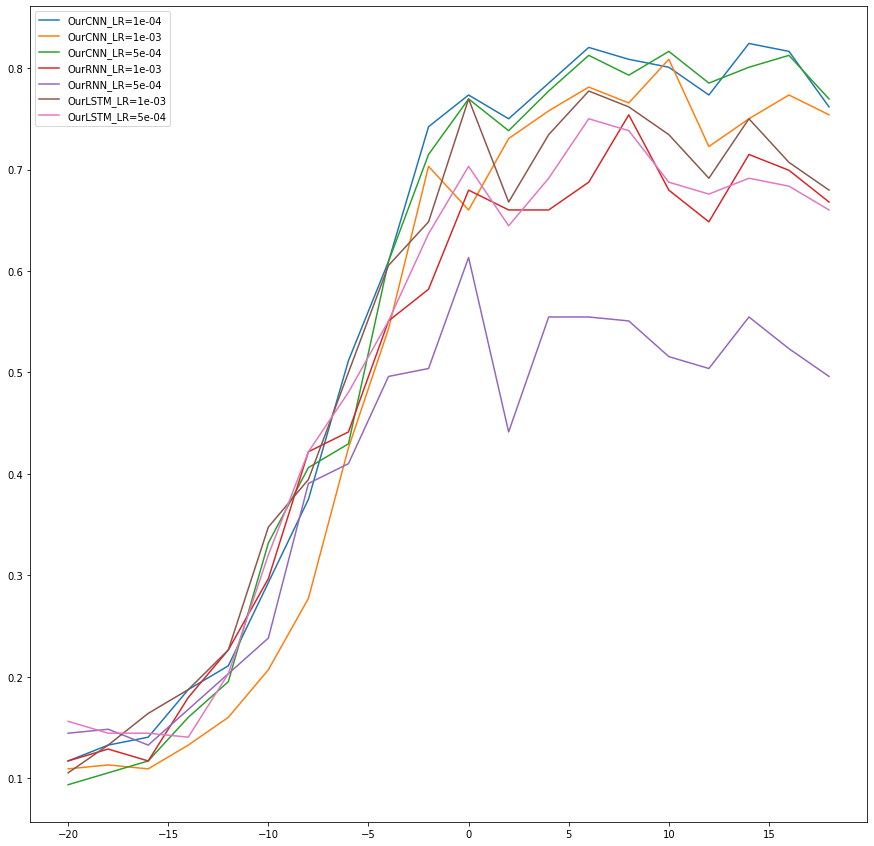

In [31]:
# printing test accuracies
for i in range(len(to_plot_raw)):
    test_accuracies = to_plot_raw[i][1]
    snrs = list(test_accuracies.keys())
    acc = list(test_accuracies.values()) 
    plt.plot(snrs, acc, label=plot_names_row[i])

plt.legend()
plt.show()

In [35]:
# printing test accuracies
for i in range(len(to_plot_raw)):
    print("\n")
    print("---- MODEL:", plot_names_row[i], "-----")
    test_accuracies = to_plot_raw[i][1]
    print("{:<8} {:<15}".format('SNR','Accuracy'))
    for k, v in test_accuracies.items():
      print("{:<8} {:<15}".format(k, v))
    print("\n")



---- MODEL: OurCNN_LR=1e-04 -----
SNR      Accuracy       
-20      0.1171875      
-18      0.1328125      
-16      0.140625       
-14      0.1875         
-12      0.2109375      
-10      0.29296875     
-8       0.375          
-6       0.51171875     
-4       0.609375       
-2       0.7421875      
0        0.7734375      
2        0.75           
4        0.78515625     
6        0.8203125      
8        0.80859375     
10       0.80078125     
12       0.7734375      
14       0.82421875     
16       0.81640625     
18       0.76171875     




---- MODEL: OurCNN_LR=1e-03 -----
SNR      Accuracy       
-20      0.109375       
-18      0.11328125     
-16      0.109375       
-14      0.1328125      
-12      0.16015625     
-10      0.20703125     
-8       0.27734375     
-6       0.42578125     
-4       0.54296875     
-2       0.703125       
0        0.66015625     
2        0.73046875     
4        0.7578125      
6        0.78125        
8        0.765625       
1

### Confusion Matrices

In [55]:
def plot_cf(cm, cmap=plt.cm.Greens, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title("CF")
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True')
  plt.xlabel('Pred')

In [65]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

In [57]:
# conf mats on best ckpt:

# test sets for each SNR
ckpt = 'OurCNN_raw_colab_10epochs_b256_lr0.0001_weighted/epoch=8_step=28062_val_acc_epoch=0.54833.ckpt'
batch_size = 256
average = 'weighted'
model_name = 'OurCNN'
feature = 'raw'

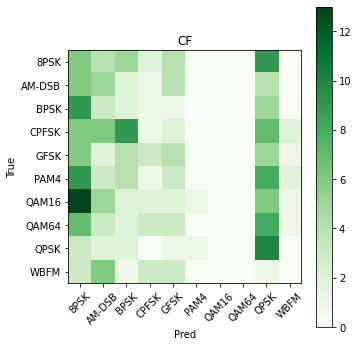

In [66]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[0], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

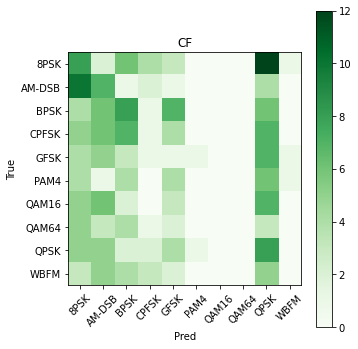

In [67]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[1], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

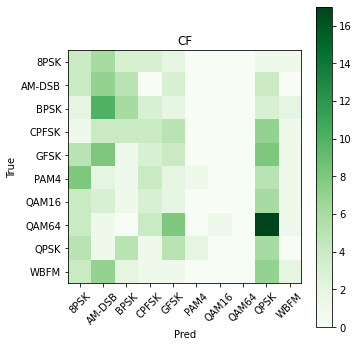

In [68]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[2], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

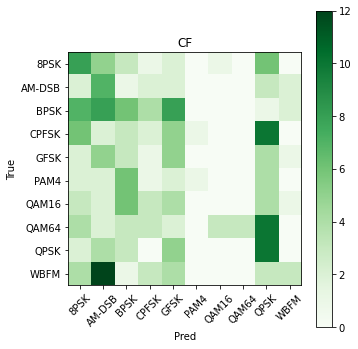

In [69]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[3], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

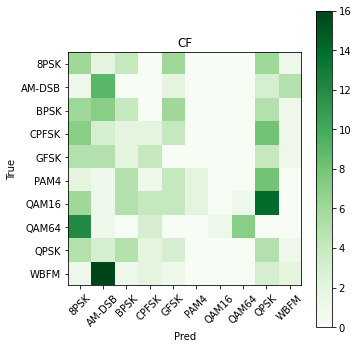

In [70]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[4], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

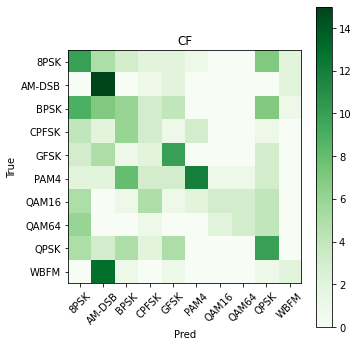

In [71]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[5], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

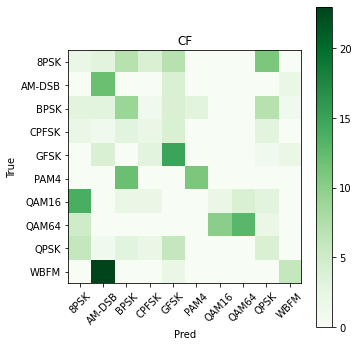

In [72]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[6], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

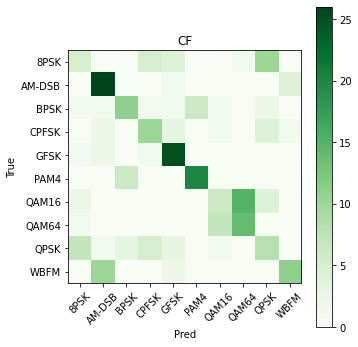

In [84]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[7], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

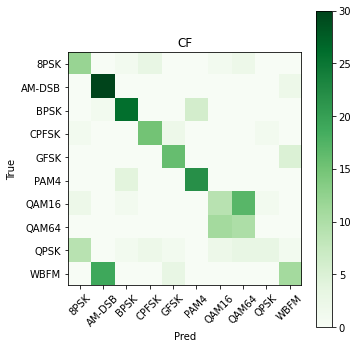

In [83]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[8], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

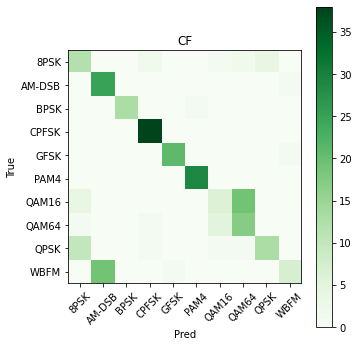

In [82]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[9], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

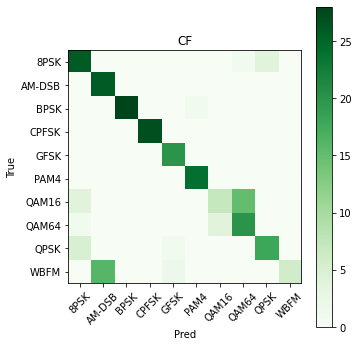

In [81]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[10], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

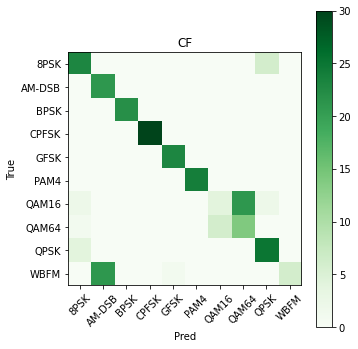

In [80]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[11], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

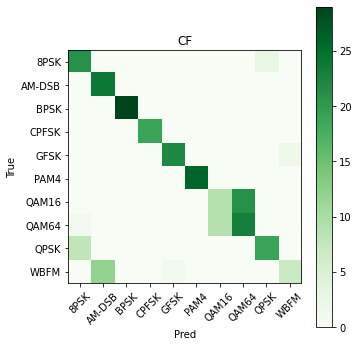

In [79]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[12], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

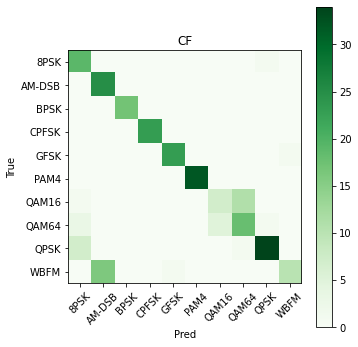

In [78]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[13], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

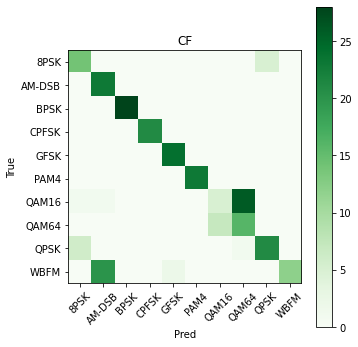

In [77]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[14], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

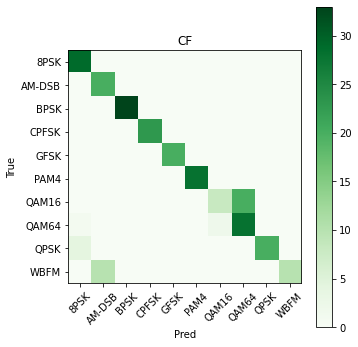

In [76]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[15], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

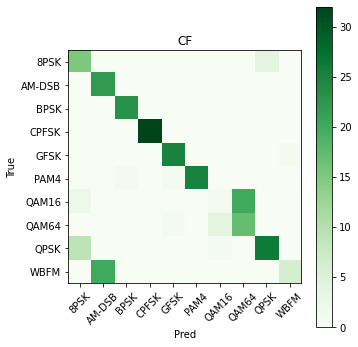

In [75]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[16], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

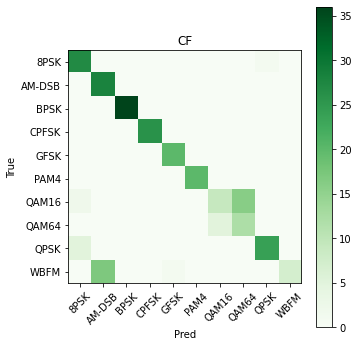

In [74]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[17], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

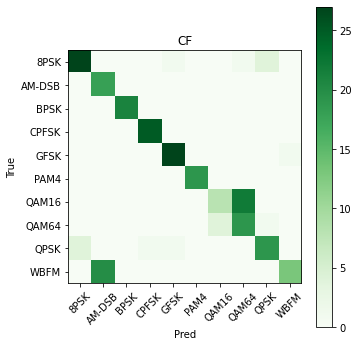

In [73]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[18], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

In [ ]:
matrix = compare_conf_mat(ckpt, model_name, feature, snrs[19], batch_size, average)
plot_cf(matrix, labels=modulations)
plt.show()

### Testing on DT Features

In [ ]:
# test sets for each SNR
ckpts = ['OurCNN_dt_colab_10epochs_b256_lr0.001_weighted/epoch=2_step=9354_val_acc_epoch=0.19350.ckpt',
         'OurRNN_dt_colab_10epochs_b256_lr0.001_weighted/epoch=8_step=28062_val_acc_epoch=0.32593.ckpt',
         'OurLSTM_dt_colab_10epochs_b256_lr0.001_weighted/epoch=7_step=24944_val_acc_epoch=0.35488.ckpt']
model_names = ['OurCNN', 'OurRNN', 'OurLSTM']
batch_size = 256
average = 'weighted'
to_plot_dt = {}
for i in range(len(ckpts)):
    ckpt = ckpts[i]
    model_name = model_names[i]
    feature = 'dt'
    test_acc = {}
    val_acc = {}
    for snr in snrs:
        val_acc[snr], test_acc[snr] = compare(ckpt, model_name, feature, snr, batch_size, average)
    to_plot_dt[i] = val_acc, test_acc

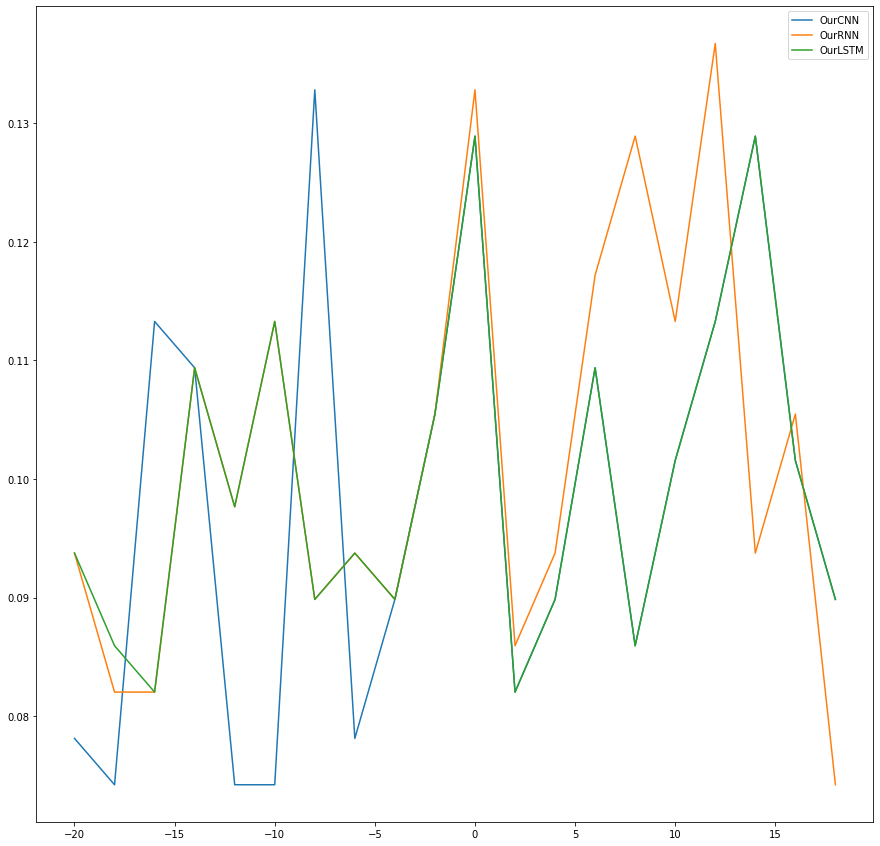

In [34]:
# printing test accuracies
for i in range(len(to_plot_dt)):
    test_accuracies = to_plot_dt[i][1]
    snrs = list(test_accuracies.keys())
    acc = list(test_accuracies.values()) 
    plt.plot(snrs, acc, label=model_names[i])

plt.legend()
plt.show()

In [36]:
# printing test accuracies
for i in range(len(to_plot_dt)):
    print("\n")
    print("---- MODEL:", model_names[i], "-----")
    test_accuracies = to_plot_dt[i][1]
    print("{:<8} {:<15}".format('SNR','Accuracy'))
    for k, v in test_accuracies.items():
      print("{:<8} {:<15}".format(k, v))
    print("\n")



---- MODEL: OurCNN -----
SNR      Accuracy       
-20      0.078125       
-18      0.07421875     
-16      0.11328125     
-14      0.109375       
-12      0.07421875     
-10      0.07421875     
-8       0.1328125      
-6       0.078125       
-4       0.08984375     
-2       0.10546875     
0        0.12890625     
2        0.08203125     
4        0.08984375     
6        0.109375       
8        0.0859375      
10       0.1015625      
12       0.11328125     
14       0.12890625     
16       0.1015625      
18       0.08984375     




---- MODEL: OurRNN -----
SNR      Accuracy       
-20      0.09375        
-18      0.08203125     
-16      0.08203125     
-14      0.109375       
-12      0.09765625     
-10      0.11328125     
-8       0.08984375     
-6       0.09375        
-4       0.08984375     
-2       0.10546875     
0        0.1328125      
2        0.0859375      
4        0.09375        
6        0.1171875      
8        0.12890625     
10       0.11328125